In [68]:
import numpy as np
from scipy.stats import mode
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA, FactorAnalysis
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder

### Загрузка данных. Удаление ненужного столбца.

In [69]:
df = pd.read_csv('data/train.csv')
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,salutation,dateOfBirth,state,creationDate,returnShipment
0,96218,2012-06-19,2012-06-21,182,38,red,17,109.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,1
1,96219,2012-06-19,2012-06-21,557,38,red,1,129.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,1
2,96220,2012-06-19,2012-06-21,90,38,red,24,69.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,0
3,96221,2012-06-19,2012-06-21,1,38,red,1,119.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,1
4,96222,2012-06-19,2012-06-21,1,37+,red,1,119.9,21163,Mrs,1967-03-25,Baden-Wuerttemberg,2012-06-19,1


### Поиск пропусков в данных.

In [70]:
has_null = df.isna().any()
is_null = df.isna().sum()
for col in df.columns:
    print(f"{col:<15} {'True ' if has_null[col] else 'False'}  {is_null[col]}")

orderItemID     False  0
orderDate       False  0
deliveryDate    False  0
itemID          False  0
size            False  0
color           False  0
manufacturerID  False  0
price           False  0
customerID      False  0
salutation      False  0
dateOfBirth     False  0
state           False  0
creationDate    False  0
returnShipment  False  0


In [71]:
# Приведение столбцов с датами, содержащих пропуски, к дате
df['orderDate'] = pd.to_datetime(df['orderDate'], format='%Y-%m-%d', errors='coerce')
df['deliveryDate'] = pd.to_datetime(df['deliveryDate'], format='%Y-%m-%d', errors='coerce')
df['dateOfBirth'] = pd.to_datetime(df['dateOfBirth'], format='%Y-%m-%d', errors='coerce')
df['creationDate'] = pd.to_datetime(df['creationDate'], format='%Y-%m-%d', errors='coerce')
# Вставка моды в пропуски цвета
df['color'] = df['color'].fillna(df['color'].mode()[0])

In [72]:
# Убираем оставшиеся пропуски
df['deliveryDate'] = df['deliveryDate'].fillna(df['deliveryDate'].median())
df['dateOfBirth'] = df['dateOfBirth'].fillna(df['dateOfBirth'].median())

### МММ хуета - строим графики в очередной раз

In [73]:
def scatters(df, col_name, t_name):
    tmp = df.groupby(col_name)[t_name].sum().to_dict()
    tmp_sorted = dict(sorted(tmp.items(), key=lambda item: item[1]))
    sns.scatterplot(tmp_sorted)
    del tmp, tmp_sorted

def scatters_rotated_labels(df, col_name, t_name):
    tmp = df.groupby(col_name)[t_name].sum().to_dict()
    tmp_sorted = dict(sorted(tmp.items(), key=lambda item: item[1]))
    ax = sns.scatterplot(tmp_sorted)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
    del tmp, tmp_sorted, ax

def scatters_total(df, col_name, t_name):
    tmp = df.groupby(col_name)[t_name].count().to_dict()
    tmp_sorted = dict(sorted(tmp.items(), key=lambda item: item[1]))
    sns.scatterplot(tmp_sorted)
    del tmp, tmp_sorted

def cats(df, col_name, target):
    sns.catplot(data=df, x=target, y=col_name, kind='boxen')

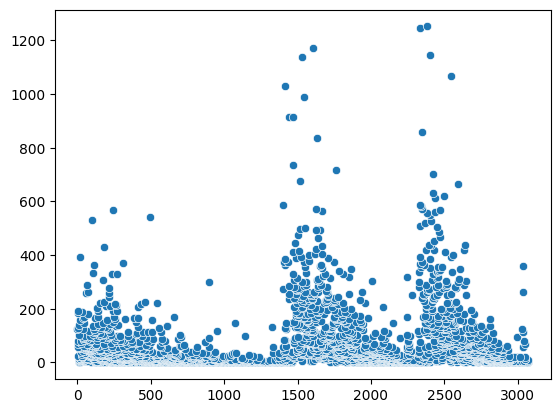

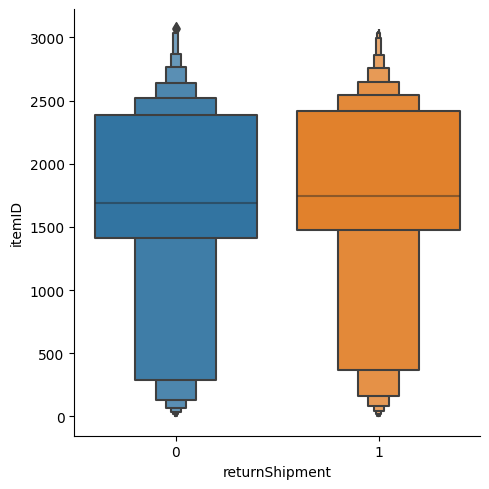

In [74]:
scatters(df, 'itemID', 'returnShipment')
cats(df, 'itemID', 'returnShipment')

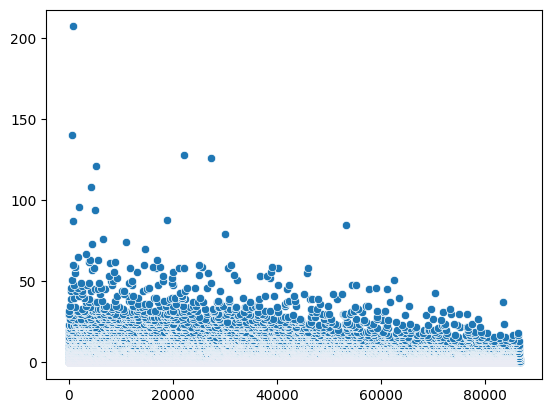

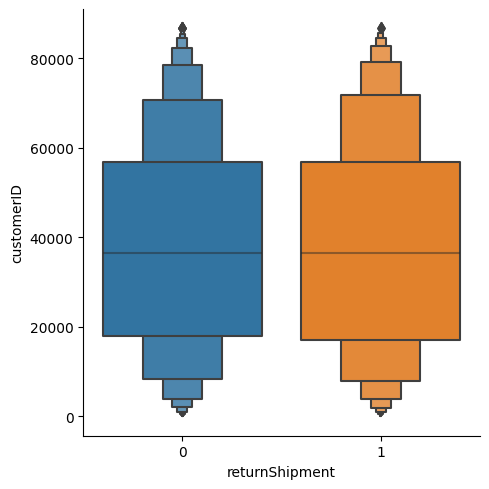

In [75]:
scatters(df, 'customerID', 'returnShipment')
cats(df, 'customerID', 'returnShipment')

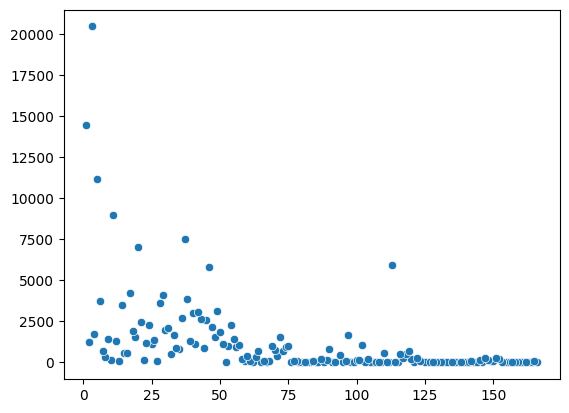

In [76]:
scatters(df, 'manufacturerID', 'returnShipment')

#### PCA как и FA посылают меня нахуй

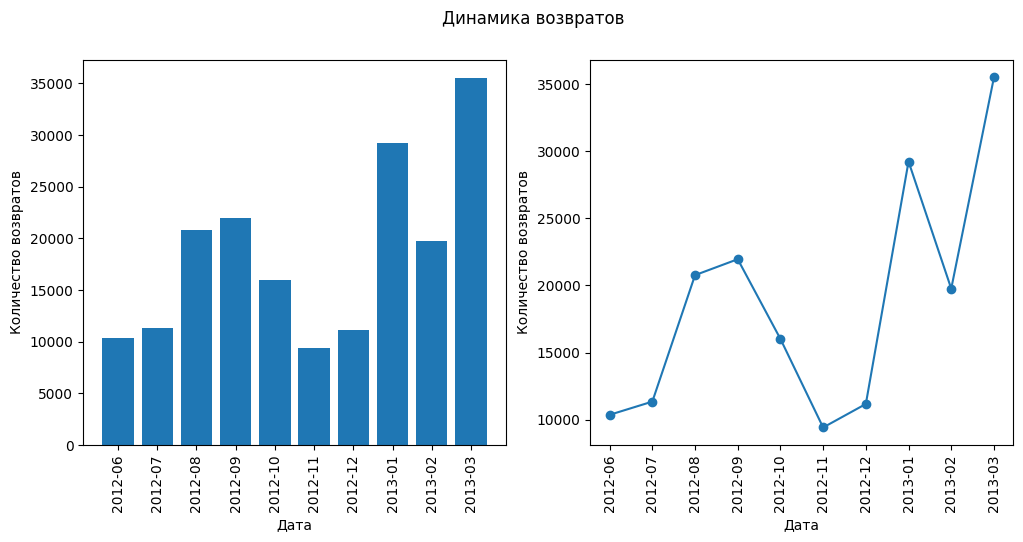

In [77]:
# По годам и месяцам заказов как всё живёт
date_stat = df
fig, axs = plt.subplots(ncols=2, figsize=(12, 5))
fig.suptitle('Динамика возвратов')
date_stat['year'] = date_stat['orderDate'].dt.year
date_stat['month'] = date_stat['orderDate'].dt.month
stats_df = date_stat.groupby(['year', 'month'])['returnShipment'].sum()
index_tuples = stats_df.index.to_list()
labels = [f"{year}-{month:02d}" for year, month in index_tuples]
axs[0].bar(x=range(len(stats_df)), height=stats_df.values)
axs[0].set_xticks(ticks=range(len(labels)), labels=labels, rotation=90)
axs[0].set_xlabel('Дата')
axs[0].set_ylabel('Количество возвратов')
axs[1].plot(stats_df.values)
axs[1].scatter(x=range(len(stats_df)) ,y=stats_df.values)
axs[1].set_xticks(ticks=range(len(labels)), labels=labels, rotation=90)
axs[1].set_xlabel('Дата')
axs[1].set_ylabel('Количество возвратов')
plt.show()
del date_stat, stats_df, index_tuples, labels, fig, axs

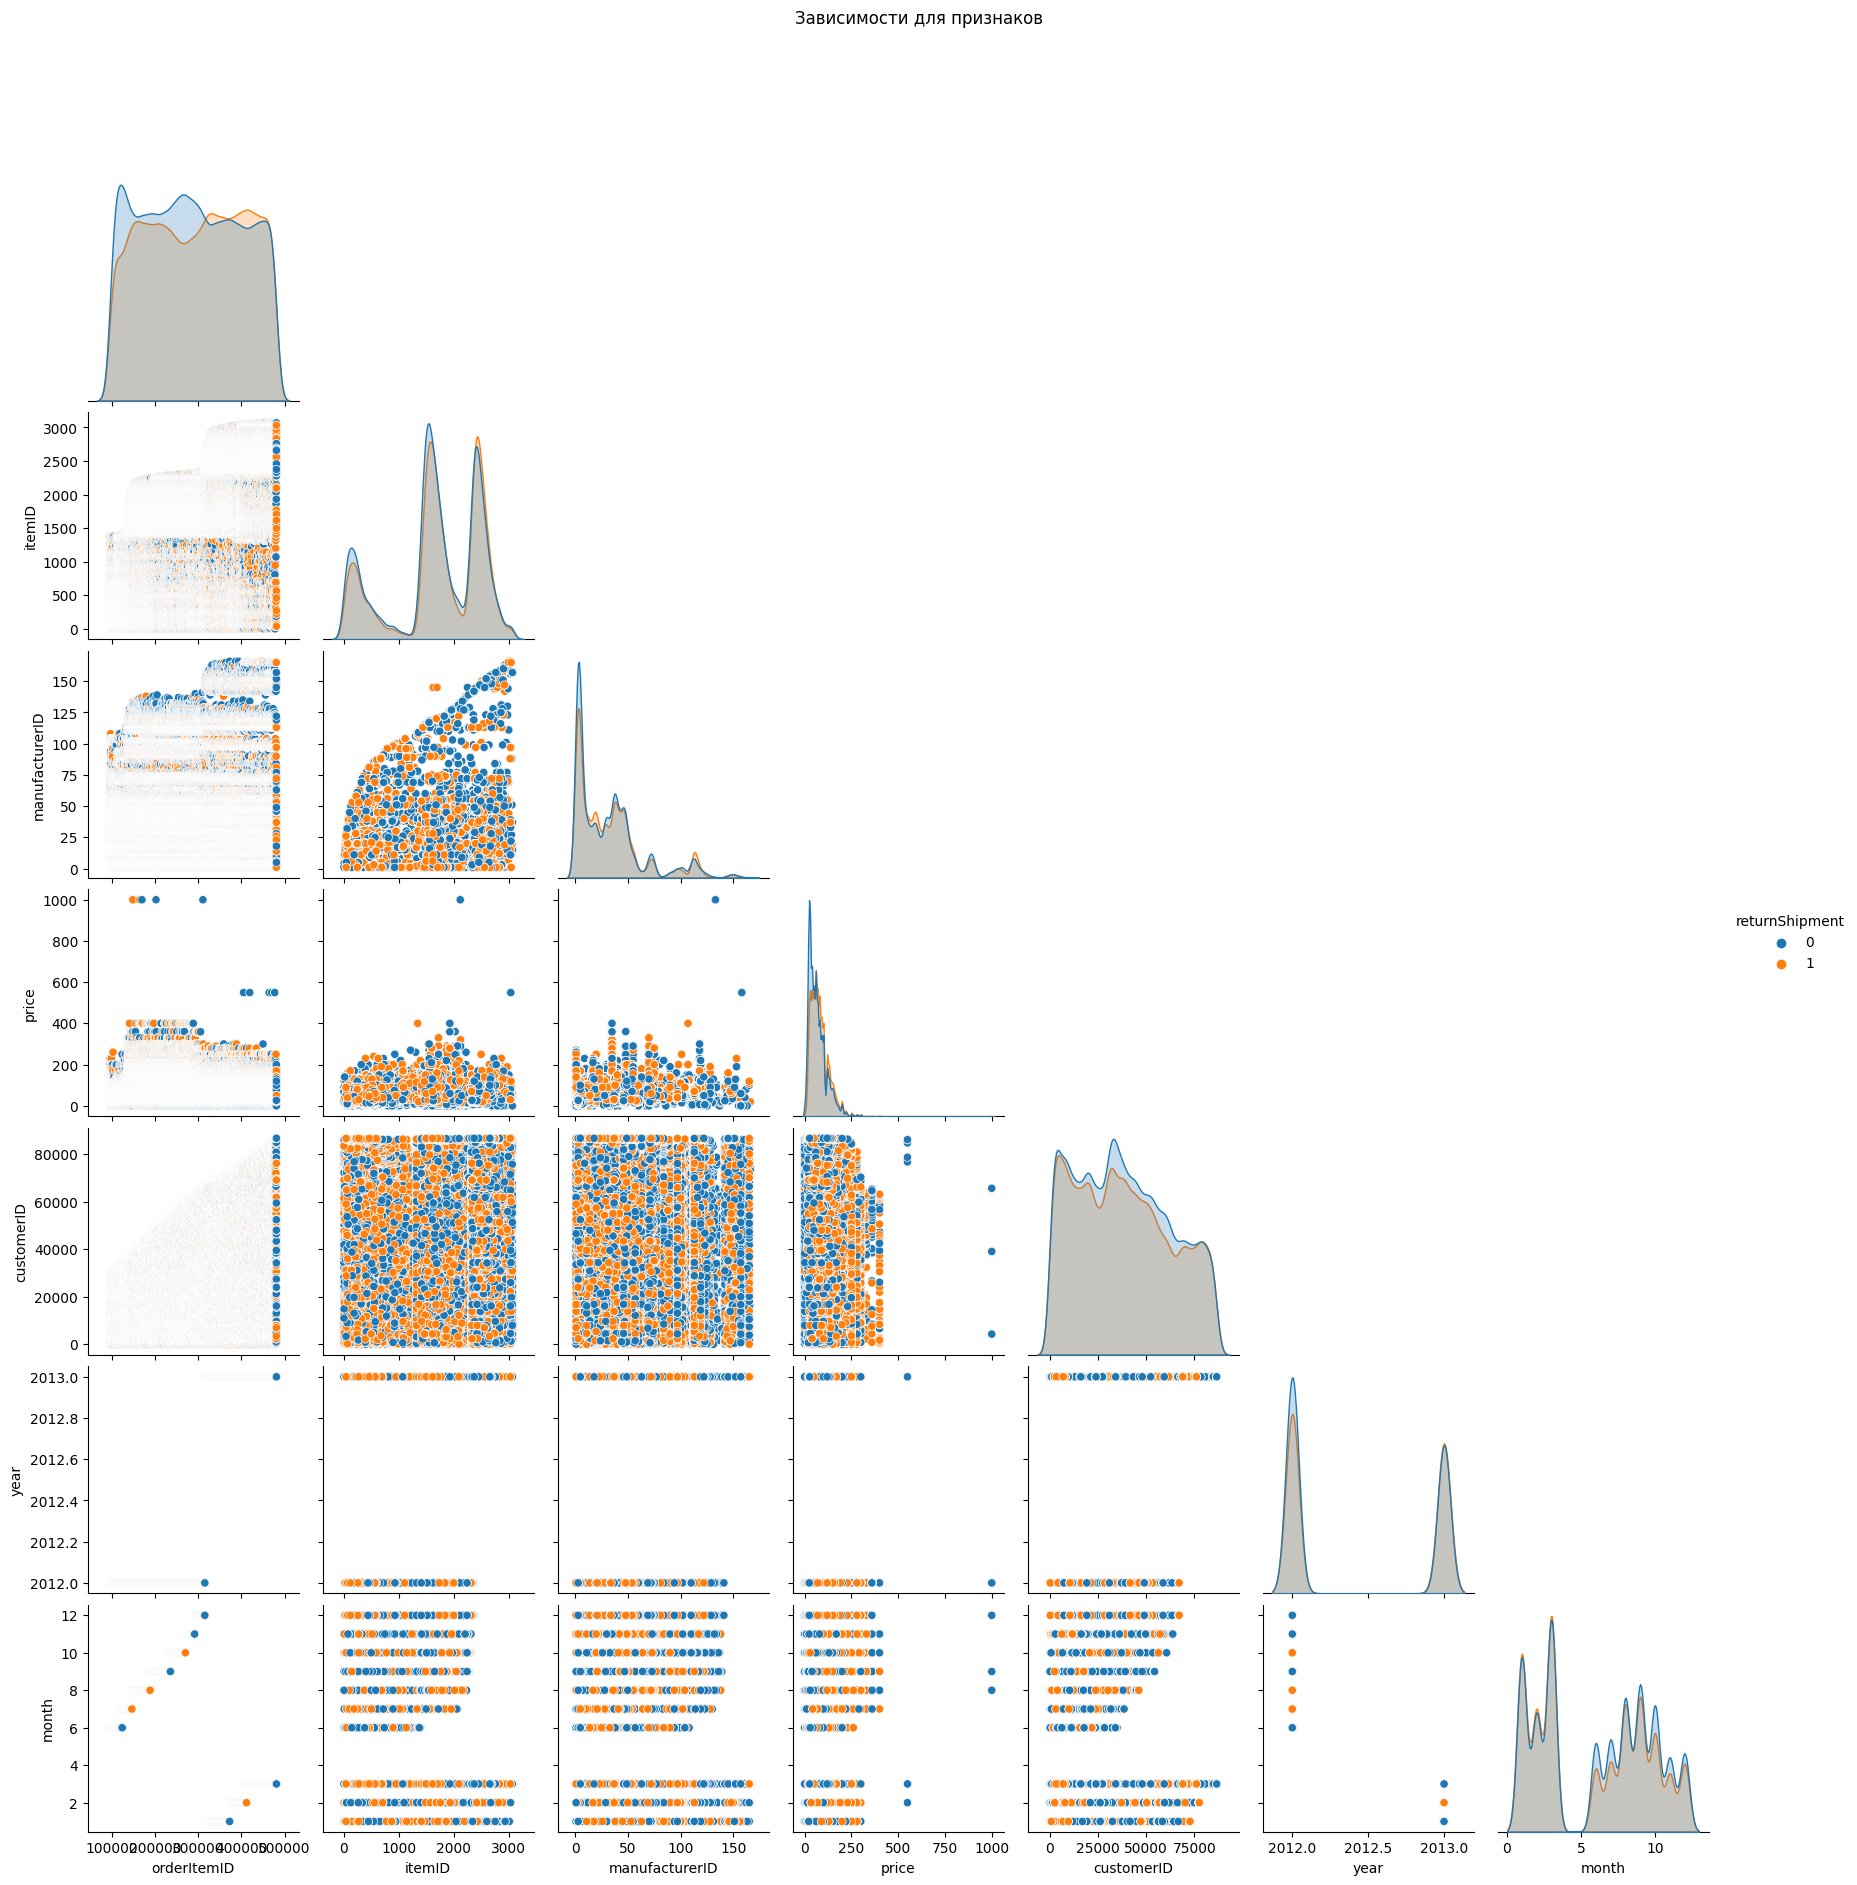

In [266]:
sns.pairplot( # матрица диаграмм рассеяния из Seaborn
data = df, # данные
hue = 'returnShipment', # имя столбца в данных для раскраски меток
corner = True # матрица симметрична, не будем выводить лишние графики
).fig.suptitle( # настройки заголовка
'Зависимости для признаков', # заголовок
y = 1.08 # расположение
);

Если бы данные сразу позволили разделить классы это было бы удивительно.

In [78]:
# Возраст человека, аккаунта, длительность доставки и ещё раз пиздануть pairplot
df['ageHuman'] = ((dt.datetime.now() - df['dateOfBirth']).dt.days / 365).astype(int)
df['ageAccount'] = ((dt.datetime.now() - df['creationDate']).dt.days / 365).astype(int)

C:\Users\egore\AppData\Local\Temp\ipykernel_10380\1313592884.py:11: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")


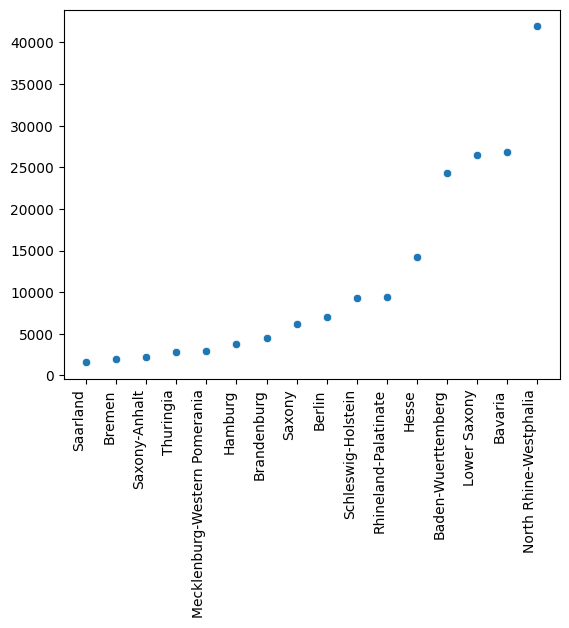

In [79]:
scatters_rotated_labels(df, 'state', 'returnShipment')

Ебать, тут нет такой же смешанной поеботы и видно зависимость. И, учитывая, что областей немного, можно использовать one-hot encoding.

In [80]:
def get_encoded(df, col_name):
    encoder = OneHotEncoder(sparse=False)
    encoder.fit(df[[col_name]])
    tmp = pd.DataFrame(data=encoder.transform(df[[col_name]]), columns=encoder.get_feature_names_out())
    df.drop(columns=[col_name], axis=1, inplace=True)
    df = pd.concat([df.reset_index(drop=True), tmp], axis=1)
    del tmp, encoder
    return df
df = get_encoded(df, 'state')

c:\Users\egore\Desktop\DMC2014\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Посмотреть отношение числа покупок к количеству возратов по категориям людей

In [83]:
df.groupby('salutation').agg({'returnShipment': ['count', 'sum']}).assign(ratio=lambda x: x[('returnShipment', 'sum')] / x[('returnShipment', 'count')])

returnShipment             ratio
                      count     sum          
salutation                                   
Company                 256     130  0.507812
Family                 1443     644  0.446292
Mr                    13746    5604  0.407682
Mrs                  369115  179018  0.484992
not reported            315      94  0.298413

In [84]:
df = get_encoded(df, 'salutation')

c:\Users\egore\Desktop\DMC2014\.venv\lib\site-packages\sklearn\preprocessing\_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


По приколу можно и обучить модель

In [85]:
df.columns

Index(['orderItemID', 'orderDate', 'deliveryDate', 'itemID', 'size', 'color',
       'manufacturerID', 'price', 'customerID', 'dateOfBirth', 'creationDate',
       'returnShipment', 'year', 'month', 'ageHuman', 'ageAccount',
       'state_Baden-Wuerttemberg', 'state_Bavaria', 'state_Berlin',
       'state_Brandenburg', 'state_Bremen', 'state_Hamburg', 'state_Hesse',
       'state_Lower Saxony', 'state_Mecklenburg-Western Pomerania',
       'state_North Rhine-Westphalia', 'state_Rhineland-Palatinate',
       'state_Saarland', 'state_Saxony', 'state_Saxony-Anhalt',
       'state_Schleswig-Holstein', 'state_Thuringia', 'salutation_Company',
       'salutation_Family', 'salutation_Mr', 'salutation_Mrs',
       'salutation_not reported'],
      dtype='object')

Для цвета можно использовать label encoding

In [88]:
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV
X = df[['itemID',
       'manufacturerID', 'price', 'customerID',
       'year', 'month', 'ageHuman', 'ageAccount',
       'state_Baden-Wuerttemberg', 'state_Bavaria', 'state_Berlin',
       'state_Brandenburg', 'state_Bremen', 'state_Hamburg', 'state_Hesse',
       'state_Lower Saxony', 'state_Mecklenburg-Western Pomerania',
       'state_North Rhine-Westphalia', 'state_Rhineland-Palatinate',
       'state_Saarland', 'state_Saxony', 'state_Saxony-Anhalt',
       'state_Schleswig-Holstein', 'state_Thuringia', 'salutation_Company',
       'salutation_Family', 'salutation_Mr', 'salutation_Mrs',
       'salutation_not reported']]
y = df['returnShipment']
param_grid = {'learning_rate': [0.1, 0.01, 0.001, 0.03],
              'max_depth': [3, 5, 7],
              'n_estimators': [10, 50, 100, 150, 200]
              }
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
model = XGBClassifier(n_estimators=100, objective='binary:logistic')
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, verbose=2)
grid_search.fit(X_train, y_train)
best_estimator = grid_search.best_estimator_
y_pred = best_estimator.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred))
print("Recall:", recall_score(y_test, y_pred))
print("F1-score:", f1_score(y_test, y_pred))

Fitting 5 folds for each of 60 candidates, totalling 300 fits
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=10; total time=   0.8s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=10; total time=   0.8s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=10; total time=   0.6s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=10; total time=   0.7s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=10; total time=   0.6s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   2.3s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   2.5s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   2.4s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   2.4s
[CV] END ....learning_rate=0.1, max_depth=3, n_estimators=50; total time=   2.5s
[CV] END ...learning_rate=0.1, max_depth=3, n_estimators=100; total time=   4.9s
[CV] END ...learning_rate=0.1, max_depth=3, n_e

In [66]:
df.head()

,orderItemID,orderDate,deliveryDate,itemID,size,color,manufacturerID,price,customerID,dateOfBirth,...,state_Saarland,state_Saxony,state_Saxony-Anhalt,state_Schleswig-Holstein,state_Thuringia,salutation_Company,salutation_Family,salutation_Mr,salutation_Mrs,salutation_not reported
0,96218,2012-06-19,2012-06-21,182,38,red,17,109.9,21163,1967-03-25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,96219,2012-06-19,2012-06-21,557,38,red,1,129.9,21163,1967-03-25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,96220,2012-06-19,2012-06-21,90,38,red,24,69.9,21163,1967-03-25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,96221,2012-06-19,2012-06-21,1,38,red,1,119.9,21163,1967-03-25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,96222,2012-06-19,2012-06-21,1,37+,red,1,119.9,21163,1967-03-25,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


В дате рождения наверное смысла особенного заполнять пропуски нет и можно просто дропнуть, а в дате доставки удалить только те, в которых deltime < ordertime

### Сравнение распределения на обучающей и тестовой выборке

In [84]:
test = pd.read_csv('data/test.csv')
test.drop('Unnamed: 0', axis=1, inplace=True)

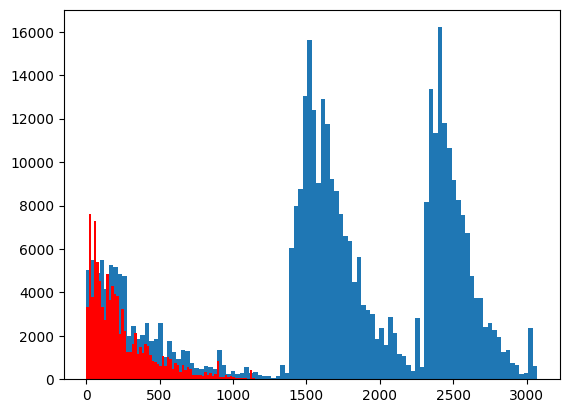

In [106]:
plt.hist(df['itemID'], bins=100)
plt.hist(test['itemID'], color='red', bins=80);

Меньше половины товаров есть на тесте, а ещё вроде бы 2 трети покупателей нахуй пропали из теста, но это нужно будет проверить.